In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def view_housing_data(file_path):
    # Read the CSV file into a DataFrame
    try:
        housing_data = pd.read_csv(file_path)
        # Display the first few rows of the DataFrame
        display(housing_data.head())
        return housing_data
    except FileNotFoundError:
        print("File not found. Please check the file path and try again.")
        return None

# Specify the path to your housing.csv file
file_path = "/Users/sm/Developer/ProjeXts/Calefornia Housing Predictions (1990)/model/datasets/housing/housing.csv"

# Call the function to view the housing data
housing = view_housing_data(file_path)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set), len(test_set))

16512 4128


In [7]:
housing = train_set.drop("median_house_value", axis=1)

housing_labels = train_set["median_house_value"].copy()

In [8]:
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,INLAND
17848,-122.49,37.79,52.0,2488.0,281.0,805.0,295.0,10.7058,NEAR BAY
6252,-123.38,41.80,25.0,1941.0,477.0,1000.0,390.0,2.2976,INLAND
9389,-118.41,34.29,32.0,1591.0,320.0,1818.0,306.0,4.2969,<1H OCEAN
6113,-119.95,38.94,24.0,2180.0,517.0,755.0,223.0,2.5875,INLAND
6061,-122.66,38.47,23.0,2246.0,437.0,1035.0,386.0,3.7617,<1H OCEAN


In [9]:
housing_labels.head(10)

14196    291000.0
8267     156100.0
17445    353900.0
14265    241200.0
2271      53800.0
17848    500001.0
6252      54400.0
9389     145800.0
6113     173400.0
6061     172600.0
Name: median_house_value, dtype: float64

# Data Cleaning

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>, <Axes: >]],
      dtype=object)

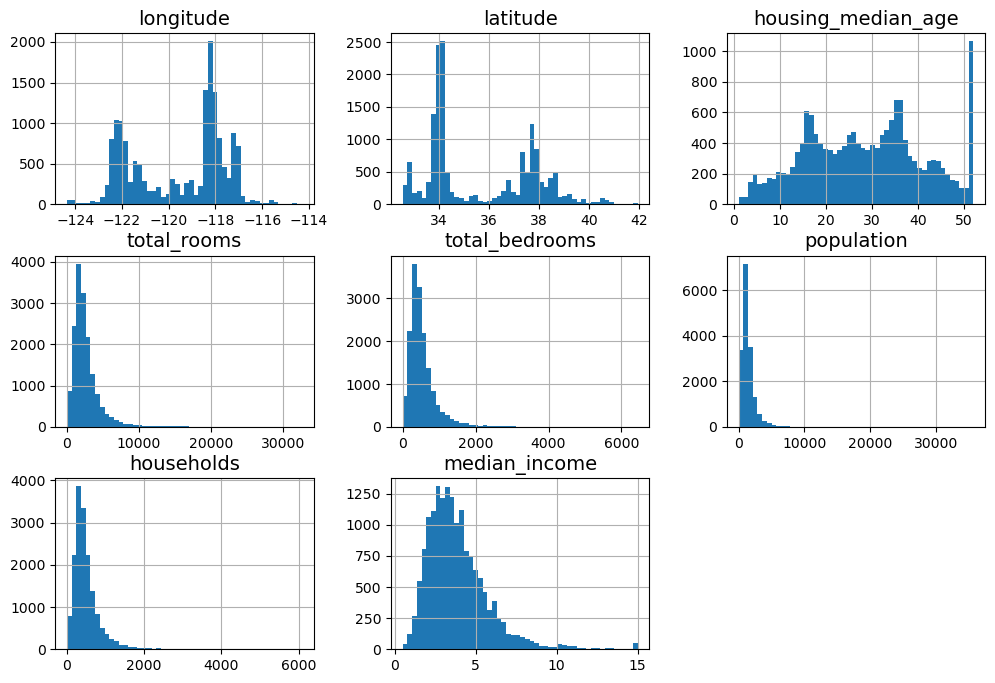

In [10]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))


In [11]:
from sklearn import set_config

set_config(display='diagram')

In [12]:
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans 
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
  

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
    
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cat_pipeline = make_pipeline(  
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

#now let's run the preprocessing pipeline
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("logs_of_data", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("categorical_data", cat_pipeline, ['ocean_proximity']),
        ("geo_data", cluster_simil, ["latitude", "longitude"]),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

housing_prepared = preprocessing.fit_transform(train_set)


In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x15f...
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('categorical_data',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('geo_data',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude'])])),
                ('linearregression', LinearRegression())])

In [14]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,INLAND


In [15]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([263900., 200000., 276200., 282300.,  52400.])

In [16]:
housing_labels.iloc[:5].values

array([291000., 156100., 353900., 241200.,  53800.])

In [17]:
# extra code – computes the error ratios discussed in the book
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-9.3%, 28.1%, -22.0%, 17.0%, -2.6%


In [18]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

lin_rmse

68747.10164439373

In [19]:
#lets try with a decision treefrom sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x15f...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('categorical_data',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('geo_data',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [20]:
housing_predictions_tree = tree_reg.predict(housing)

tree_rmse = mean_squared_error(housing_labels, housing_predictions_tree, squared=False)

tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [21]:
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmse).describe()


count       10.000000
mean     65412.071405
std       1988.576727
min      62524.412591
25%      63687.062240
50%      65575.193678
75%      67091.303613
max      67835.903323
dtype: float64

A standard deviation of 1988 is not even good. The decision tree also has an RMSE mean of 64412,07. Let's try the random forrest and see how well our model performs